## Import Modules

In [1]:
# Import modules

import os as os
import warnings

import sys
import time
import arviz             as az
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy             as np
import pandas            as pd
from sklearn.decomposition import PCA
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
import tensorflow as tf
import time

plt.style.use('seaborn')

np.random.seed(1234)
tf.random.set_seed(1234)

## Settings

In [2]:
domain_dim = 2    # dimension of the domain of the PDE
params_dim = 2    # number of parameters

x_0 = np.array([0.5,0.5])   # center of the force

boundary  = lambda x: 0 * x[:,0]
forcing   = lambda x: 10 * np.exp(-50 * np.sqrt( np.power(x[:,0] - x_0[0], 2) + np.power(x[:,1] - x_0[1], 2) ))

train_split = 0.9     # Tentative proportion of training points wrt validation points


## Load data

In [3]:
path_to_tables = os.path.join(os.getcwd(), 'generate_tables')

data_all = pd.read_csv (os.path.join(path_to_tables, 'solutions.csv'), names = ('x','y','mu','theta','u'))

# Values of mu and theta
mus    = data_all   ['mu'].unique()
thetas = data_all['theta'].unique()

# Physical points
x_all  = data_all.loc[(data_all['mu'] == mus[0]) & (data_all['theta'] == thetas[0])][['x','y']].to_numpy()

# Dimension of the Matrix
n = x_all.shape[0]
p = len(mus) * len(thetas)

## Reshape Data

In [4]:
# Reshaped dataset and parameters
data_all_reshaped = data_all.loc[(data_all['mu'] == mus[0]) & (data_all['theta'] == thetas[0])][['u']].to_numpy()

p_all = np.array(([[mus[0],thetas[0]]]))

for mu in mus:
    for theta in thetas:
        if ((mu != mus[0]) | (theta != thetas[0])):
            
            p_current = np.array(([[mu,theta]]))
            u_current = data_all.loc[(data_all['mu'] == mu) & (data_all['theta'] == theta)][['u']].to_numpy()
            
            p_all = np.concatenate((p_all, p_current), axis = 0)
            data_all_reshaped = np.concatenate((data_all_reshaped, u_current), axis = 1)

## Build Model

In [5]:
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(50, input_shape=(domain_dim+params_dim,), activation=tf.nn.tanh),
                            tf.keras.layers.Dense(50, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(50, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(50, activation=tf.nn.tanh),
                            tf.keras.layers.Dense(1)
                            ])

2021-12-06 13:33:05.177985: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-06 13:33:05.178181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 13:33:05.178920: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Build Train and Validation datasets

In [6]:
u_max = np.max(data_all['u'])
u_min = np.min(data_all['u'])
print(u_max)
print(u_min)

train_data = data_all.sample(frac=train_split)
test_data = data_all.drop(train_data.index)

train_x_p = train_data[['x','y','mu','theta']].to_numpy()
test_x_p = test_data[['x','y','mu','theta']].to_numpy()

train_u = (train_data['u'].to_numpy() - u_min)/(u_max - u_min)
test_u = (test_data['u'].to_numpy() - u_min)/(u_max - u_min)

print('________')
print(train_data.shape)
print(test_data.shape)

0.0210717112607547
0.0
________
(882090, 5)
(98010, 5)


## Training

### Set number of epochs

In [7]:
ep1 = 100     # number of epochs first training
ep2 = 50     # number of epochs second training
second_train = True     # true if I want to perform two consecutive trainings

### Compile the model for the first training

In [8]:
model.compile(loss=tf.losses.mean_squared_error,
             optimizer=tf.optimizers.Adam(learning_rate=1e-3)   
             #optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.95, nesterov=True)
             )

### First training

In [9]:
t_start = time.time()

hh1 = model.fit(x=train_x_p,
               y=train_u,
               epochs=ep1,
               batch_size=64,
               validation_data=(test_x_p,test_u))

train_time = time.time() - t_start

Epoch 1/100


2021-12-06 13:33:05.495457: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-06 13:33:05.495762: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


13783/13783 [==============================] - 35s 2ms/step - loss: 0.0022 - val_loss: 5.4995e-04
Epoch 2/100
13783/13783 [==============================] - 36s 3ms/step - loss: 5.2371e-04 - val_loss: 3.2049e-04
Epoch 3/100
13783/13783 [==============================] - 36s 3ms/step - loss: 3.1074e-04 - val_loss: 2.8115e-04
Epoch 4/100
13783/13783 [==============================] - 33s 2ms/step - loss: 2.4699e-04 - val_loss: 1.4606e-04
Epoch 5/100
13783/13783 [==============================] - 34s 2ms/step - loss: 2.1652e-04 - val_loss: 2.4731e-04
Epoch 6/100
13783/13783 [==============================] - 31s 2ms/step - loss: 1.8669e-04 - val_loss: 1.0733e-04
Epoch 7/100
13783/13783 [==============================] - 33s 2ms/step - loss: 1.5433e-04 - val_loss: 1.4168e-04
Epoch 8/100
13783/13783 [==============================] - 35s 3ms/step - loss: 1.5698e-04 - val_loss: 1.0768e-04
Epoch 9/100
13783/13783 [==============================] - 36s 3ms/step - loss: 1.4566e-04 - val_loss: 1

13783/13783 [==============================] - 31s 2ms/step - loss: 5.8431e-05 - val_loss: 3.6235e-05
Epoch 73/100
13783/13783 [==============================] - 32s 2ms/step - loss: 5.5083e-05 - val_loss: 3.1991e-05
Epoch 74/100
13783/13783 [==============================] - 30s 2ms/step - loss: 5.7297e-05 - val_loss: 8.7248e-05
Epoch 75/100
13783/13783 [==============================] - 33s 2ms/step - loss: 5.6675e-05 - val_loss: 2.3024e-05
Epoch 76/100
13783/13783 [==============================] - 31s 2ms/step - loss: 5.6017e-05 - val_loss: 2.4494e-05
Epoch 77/100
13783/13783 [==============================] - 30s 2ms/step - loss: 5.7414e-05 - val_loss: 3.1911e-05
Epoch 78/100
13783/13783 [==============================] - 33s 2ms/step - loss: 4.9987e-05 - val_loss: 1.4750e-04
Epoch 79/100
13783/13783 [==============================] - 33s 2ms/step - loss: 4.8834e-05 - val_loss: 2.8242e-05
Epoch 80/100
13783/13783 [==============================] - 33s 2ms/step - loss: 5.0424e-05 -

### Visualize results

[0.26896552 2.16661562]


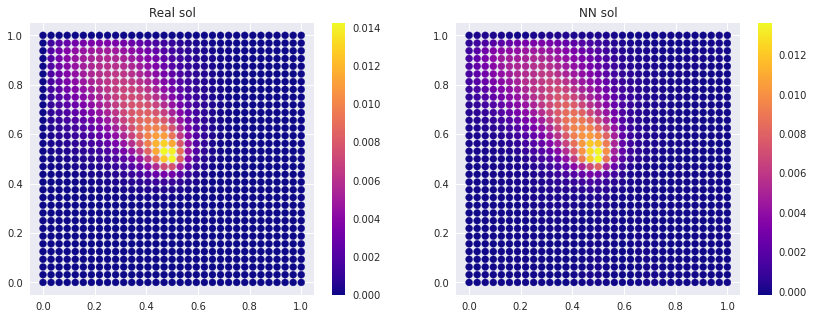

In [10]:
# select which solution to plot
sample_try = 40
print(p_all[sample_try,:])

p_try = np.tile(p_all[sample_try,:],(n,1))
x_p_try = np.hstack((x_all, p_try))

u_try = data_all_reshaped[:,sample_try]                     # real solution

u_recon = model.predict(x_p_try)*(u_max - u_min) + u_min    # reconstructed solution

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax = ax.ravel()

im = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')
ax[0].set_title('Real sol');
plt.colorbar(im, ax=ax[0])

im = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');
plt.colorbar(im, ax=ax[1])
ax[1].set_title('NN sol');

plt.savefig('Output')

### Loss visualization

________________

Training Runtime: 3463.223974943161 seconds
________________


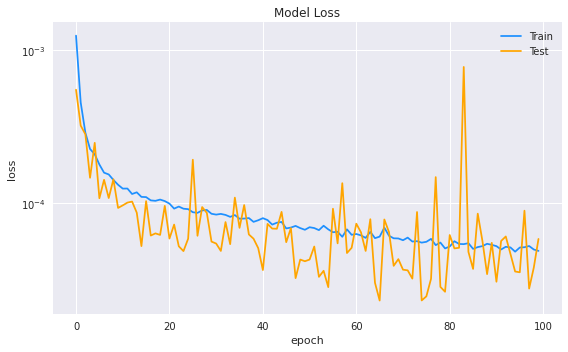

In [11]:
print('________________')
print(f'\nTraining Runtime: {train_time} seconds')
print('________________')

full_loss = hh1.history['loss']
full_val_loss = hh1.history['val_loss']

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(full_loss, color='dodgerblue')
ax.plot(full_val_loss, color='orange')
ax.set_yscale('log')
ax.set_title('Model Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.tight_layout()

plt.savefig('Model_loss')

### (Eventually) perform a second training

In [13]:
if second_train:

    weights = model.get_weights()

    model.compile(loss=tf.losses.mean_squared_error,
                 # optimizer=tf.optimizers.Adadelta()                 
                  #optimizer=tf.optimizers.Adam(learning_rate=1e-3)   
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
                 )

    model.set_weights(weights)
    
    t_start = time.time()
    
    hh2 = model.fit(x=train_x_p,
                   y=train_u,
                   epochs=ep2,
                   batch_size=64,
                   validation_data=(test_x_p,test_u))
    
    train_time = time.time() - t_start

Epoch 1/50
13783/13783 [==============================] - 28s 2ms/step - loss: 1.0988e-05 - val_loss: 1.0855e-05
Epoch 2/50
13783/13783 [==============================] - 28s 2ms/step - loss: 1.0303e-05 - val_loss: 1.0129e-05
Epoch 3/50
13783/13783 [==============================] - 27s 2ms/step - loss: 1.0333e-05 - val_loss: 1.0256e-05
Epoch 4/50
13783/13783 [==============================] - 27s 2ms/step - loss: 1.0003e-05 - val_loss: 1.0277e-05
Epoch 5/50
13783/13783 [==============================] - 28s 2ms/step - loss: 9.6727e-06 - val_loss: 9.7320e-06
Epoch 6/50
13783/13783 [==============================] - 30s 2ms/step - loss: 9.6203e-06 - val_loss: 9.5926e-06
Epoch 7/50
13783/13783 [==============================] - 28s 2ms/step - loss: 9.5671e-06 - val_loss: 9.3452e-06
Epoch 8/50
13783/13783 [==============================] - 29s 2ms/step - loss: 9.3646e-06 - val_loss: 9.5683e-06
Epoch 9/50
13783/13783 [==============================] - 29s 2ms/step - loss: 9.1552e-06 - val_

In [ ]:
if second_train:

    sample_try = 354
    print(p_all[sample_try,:])

    p_try = np.tile(p_all[sample_try,:],(n,1))
    x_p_try = np.hstack((x_all, p_try))

    u_try = data_all_reshaped[:,sample_try]

    u_recon = model.predict(x_p_try)*(u_max - u_min) + u_min

    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax = ax.ravel()

    im = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')
    ax[0].set_title('Real sol');
    plt.colorbar(im, ax=ax[0])

    im = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title('NN sol');

    plt.savefig('Output_second')

________________

Training Runtime: 1450.153223991394 seconds
________________


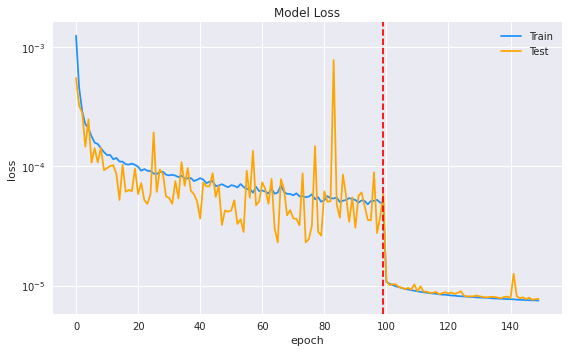

In [15]:
 if second_train:  
        
    print('________________')
    print(f'\nTraining Runtime: {train_time} seconds')
    print('________________')
    
    full_loss = hh1.history['loss'] + hh2.history['loss']
    full_val_loss = hh1.history['val_loss'] + hh2.history['val_loss']

    fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.plot(full_loss, color='dodgerblue')
    ax.plot(full_val_loss, color='orange')
    ax.axvline(x=(ep1-1), color='red', linestyle='--')
    ax.set_yscale('log')
    ax.set_title('Model Loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='best')

    plt.tight_layout()

    plt.savefig('Model_loss_second')

## Save the model

In [16]:
model.save('red_model')

2021-12-06 15:00:27.156228: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: red_model/assets


## Load a previously saved model

[0.26896552 2.16661562]


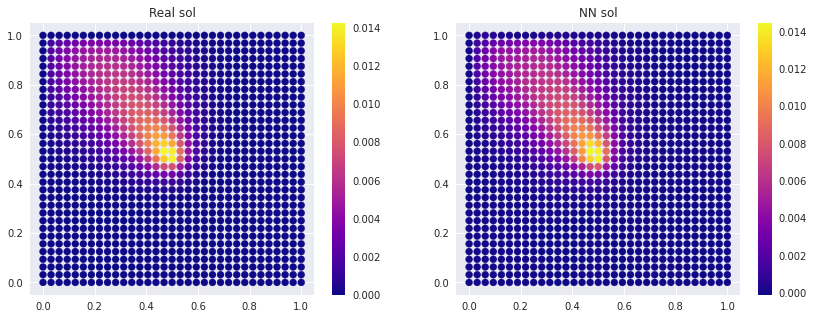

In [22]:

load_model = tf.keras.models.load_model('red_model')

sample_try = 40
print(p_all[sample_try,:])
p_try = np.tile(p_all[sample_try,:],(n,1))
x_p_try = np.hstack((x_all, p_try))

u_try = data_all_reshaped[:,sample_try]

u_recon = load_model.predict(x_p_try)*(u_max - u_min) + u_min

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax = ax.ravel()

im = ax[0].scatter(x_all[:,0], x_all[:,1], c=u_try, cmap='plasma')
ax[0].set_title('Real sol');
plt.colorbar(im, ax=ax[0])

im = ax[1].scatter(x_all[:,0], x_all[:,1], c=u_recon, cmap='plasma');
plt.colorbar(im, ax=ax[1])
ax[1].set_title('NN sol');

plt.savefig('Output')
